This is an example of a [SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model) model, which is a compartmental model used in epidemiology to similuate the propagation of an infectious desease.

This work is inspired by the work of Gabriel Goh: http://gabgoh.github.io/COVID/index.html

and the work of Patrick Sánchez : https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions

## SEIR Model

SEIR is a simple model that considers a population that belongs to one of the following states:

 1. **Susceptible (S)**. The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people
 2. **Exposed (E)**. The person is in the incubation period : he has been infected but is not yet infectious himself.
 3. **Infected (I)**. This person has contracted the disease and he starts to be infectious.
 4. **Recovered/Deceased (R)**. The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased.
 
 ![SEIR Model](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/SEIR.PNG/800px-SEIR.PNG)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp

%matplotlib inline

In [2]:
# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, E, I, R = y
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    return [S_out, E_out, I_out, R_out]

In [3]:
N = 100000  # Population size
n_infected = 1
max_days = 365

# State at time = 0 for SEIR model
a = (N - n_infected)/ N
b = 0
c = n_infected / N
d = 0.


In [4]:
def plot_model(solution, title='SEIR model'):
    sus, exp, inf, rec = solution.y

    f = plt.figure(figsize=(8,5)) 
    plt.plot(sus, 'b', label='Susceptible');
    plt.plot(exp, 'y', label='Exposed');
    plt.plot(inf, 'r', label='Infected');
    plt.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');

# Model without intervention
Let's see what the model looks like without any intervention, i.e. R_0 is a contant value

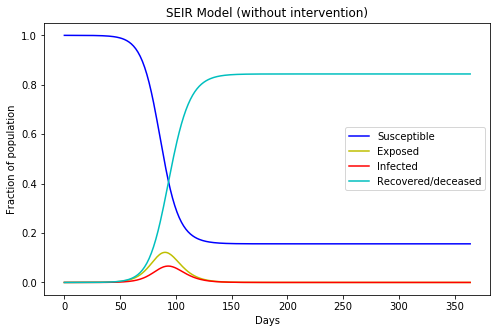

In [5]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number

sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(R_0, T_inf, T_inc), 
                t_eval=np.arange(max_days))

plot_model(sol, 'SEIR Model (without intervention)')

# Model with intervention
Lets assume that there is some intervention that causes the reproduction number (R_0) to fall to a lower value (R_t) at a certain time (e.g. physical distancing). Note that the actual drop will occur some time after the intervention measures are implemented.

This could be modified to take any function of R_t(t) values to model the reproduction number as a time varying variable

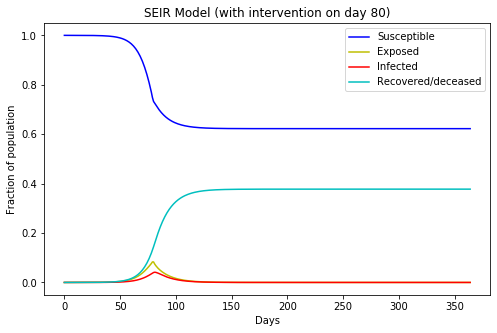

In [6]:
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 80

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0

sol2 = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(time_varying_reproduction, T_inf, T_inc), 
                t_eval=np.arange(max_days))

plot_model(sol2, f'SEIR Model (with intervention on day {intervention_day})')

Let's compare the infection rate between the two cases

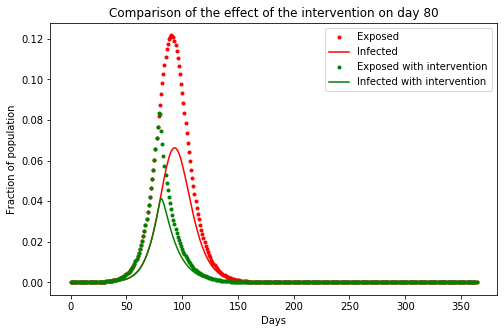

In [7]:
_, exp, inf, _ = sol.y
_, exp2, inf2, _ = sol2.y

f = plt.figure(figsize=(8,5)) 
plt.plot(exp, 'r.', label='Exposed');
plt.plot(inf, 'r', label='Infected');
plt.plot(exp2, 'g.', label='Exposed with intervention');
plt.plot(inf2, 'g', label='Infected with intervention');
plt.title(f'Comparison of the effect of the intervention on day {intervention_day}')
plt.xlabel("Days", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best');

You can see that after the intervention on day 80, the peak infections is lower than if there was no intervention